# Forces

GNNs can predict the potential energy surface of for example molecules or crystal as a function of composition and geometry with for example `Schnet` or `DimeNetPP` . If a GNN is differentiable by using differentiable update and aggregation functions with for example smooth activations like `swish` or `shifted_softplus` , then automatic differentiation within `tensorflow` and `tensorflow.keras` can derive forces as a function of the model's output.

$$\vec{F} = - \nabla \, E$$

Note that there are also (equivariant) models that directly predict energy and forces, which yields a prerformance benefit but may not guarantee that forces match the gradient of potential energy surface (integrating forces would therfore not provide strict energy conservation).

If reference gradients are available from ab-initio quantum calculations (like e.g. DFT), then models can be trained on both energy and force targets by combining their loss $\mathcal{L}$ with weights $\alpha$ and $\beta$.

$$\mathcal{L} = \alpha \; \mathcal{L}(E, \hat{E}) + \beta  \; \mathcal{L}(\vec{F}, \hat{\vec{F}}) $$

For example mean squared error or mean absolute error can be chosen as loss $\mathcal{L}$ . 

$$\mathcal{L} = \alpha \; ||E - \hat{E}||_2 + \beta  \; ||\vec{F} - \hat{\vec{F}}||_2 $$

Within ``kgcnn`` every model that has geometric inputs with e.g xyz-coordinates for each atom and that can predict a graph-level energy value can be used with the wrapper `kgcnn.model.force.EnergyForceModel` .

For example a `Schnet` model with parameters suitable for energy prediciton:

In [1]:
from kgcnn.literature.Schnet import make_model
config= {
    "name": "SchnetEnergy",
    "inputs": [
        {"shape": [None], "name": "z", "dtype": "int64"},
        {"shape": [None, 3], "name": "R", "dtype": "float32"},
        {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_ranges", "dtype": "int64"}
    ],
    "input_tensor_type": "padded",
    "input_node_embedding": {"input_dim": 95, "output_dim": 128},
    "last_mlp": {
        "use_bias": [True, True, True], "units": [128, 64, 1],
        "activation": [
            {"class_name": "function", "config": "kgcnn>shifted_softplus"}, 
            {"class_name": "function", "config": "kgcnn>shifted_softplus"}, 
            'linear'
        ]},
    "interaction_args": {
        "units": 128, "use_bias": True, 
        "activation": {"class_name": "function", "config": "kgcnn>shifted_softplus"}, 
        "cfconv_pool": "sum"
    },
    "node_pooling_args": {"pooling_method": "sum"},
    "depth": 6,
    "gauss_args": {"bins": 25, "distance": 5, "offset": 0.0, "sigma": 0.4}, "verbose": 10,
    "output_embedding": "graph",
    "use_output_mlp": False,
    "output_mlp": {}
}
model_energy = make_model(**config)

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'SchnetEnergy', 'inputs': [{'shape': [None], 'name': 'z', 'dtype': 'int64'}, {'shape': [None, 3], 'name': 'R', 'dtype': 'float32'}, {'shape': [None, 2], 'name': 'range_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_ranges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'input_embedding': None, 'cast_disjoint_kwargs': {}, 'input_node_embedding': {'input_dim': 95, 'output_dim': 128}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': {'class_name': 'function', 'config': 'kgcnn>shifted_softplus'}, 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 6, 'gauss_args': {'bins': 25, 'distance': 5, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': [True, True, True], 'units': [128, 64, 1], 'activation': [{'class_name': 'function', 'config': 'kgcnn>shifted_sof

Can be inserted into `kgcnn.model.force.EnergyForceModel` .

In [2]:
from kgcnn.models.force import EnergyForceModel

model_energy_force = EnergyForceModel(
    inputs=[
        {"shape": [None], "name": "z", "dtype": "int32"},
        {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32"},
        {"shape": [None, 2], "name": "range_indices", "dtype": "int64"},
        {"shape": (), "name": "total_nodes", "dtype": "int64"},
        {"shape": (), "name": "total_ranges", "dtype": "int64"}
    ],
    name="SchnetForce",
    model_energy = model_energy,
    output_to_tensor = False,
    output_squeeze_states = True,
    outputs={
        "energy": {"name": "energy", "shape": (1,)},
        "force": {"name": "force", "shape": (None, 3)}
    }
)

## Fit Force Model

A simple but complete training procedure to train the above `EnergyForceModel` on both energy and force labels is shown below.
Example data is the `MD17Dataset` with geometries of ethanol including energy and force labels. 

The dataset can be loaded directly from `kgcnn.data.datasets.MD17Dataset` .

In [3]:
from kgcnn.data.datasets.MD17Dataset import MD17Dataset
dataset = MD17Dataset("ethanol_ccsd_t")
dataset.map_list(method="set_range", node_coordinates="R", max_distance=4.0)
dataset.map_list(method= "count_nodes_and_edges", total_edges= "total_ranges", count_edges= "range_indices", 
                count_nodes= "z", total_nodes= "total_nodes")
# Change units to eV/A from kcal/mol
dataset.set("E", [mol["E"]*0.0433634  for mol in dataset])
dataset.set("F", [mol["F"]*0.0433634  for mol in dataset])
print("Dataset (%s):" % len(dataset), dataset[0].keys())

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.


Dataset (2000): dict_keys(['R', 'E', 'F', 'z', 'name', 'type', 'md5', 'theory', 'train', 'range_indices', 'range_attributes', 'total_nodes', 'total_ranges'])


This specific dataset has pre-defined train-test indices which can be retrieved from graph properties "train" and "test" with `get_train_test_indices()` .

In [4]:
train_index, test_index = dataset.get_train_test_indices(train="train", test="test")[0]  # Split 0
dataset_train, dataset_test = dataset[train_index], dataset[test_index]

To provide properly scaled energy and force labels for ML models, one can apply `EnergyForceExtensiveLabelScaler` to remove a energy offset and standardize the energy scale. 
This class should also work for different molecules in the dataset by removing a fitted extensive energy based on the atom spcies.

In [5]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler

# Scaling energy and forces.
scaler_mapping = {"atomic_number": "z", "energy": "E", "force": "F"}
scaler = EnergyForceExtensiveLabelScaler(standardize_scale=False, **scaler_mapping)
scaler.fit_dataset(dataset_train);
scaler.transform_dataset(dataset_train)
scaler.transform_dataset(dataset_test);

Next step is the conversion of the data in form of numpy arrays to Tensor for keras model input. This can be done with `tensor()` method of the dataset using the keras Input layer config.

In [6]:
# Conversion to tensor input
labels_in_dataset = {
    "energy": {"name": "E", "shape": (1,)},
    "force": {"name": "F", "shape": (None, 3)}
}
y_train, y_test = dataset_train.tensor(labels_in_dataset), dataset_test.tensor(labels_in_dataset)
x_train, x_test = dataset_train.tensor(config["inputs"]), dataset_test.tensor(config["inputs"])

The model is compiled with optimizer and loss for both energy and force and their respective weights with `loss_weights` . 

In [7]:
from kgcnn.losses.losses import ForceMeanAbsoluteError
from keras.optimizers import Adam

model_energy_force.compile(
    loss={"energy": "mean_absolute_error", "force": ForceMeanAbsoluteError()},
    optimizer=Adam(learning_rate=1e-03),
    metrics=None,
    loss_weights={"energy": 0.02, "force": 0.98},
)

Build the model and loss/metrics with test data.

In [8]:
model_energy_force.predict(x_test, batch_size=2, steps=2)
model_energy_force._compile_loss.build(y_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


Training with keras `fit()` and using a `LinearWarmupExponentialLRScheduler` . With a reasonable personal GPU this should take less than one hour.

In [9]:
%%capture
from kgcnn.training.scheduler import LinearWarmupExponentialLRScheduler
from kgcnn.utils.plots import plot_train_test_loss

hist = model_energy_force.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    shuffle=True,
    batch_size=32,
    epochs=1000,
    validation_freq=1,
    verbose=1,
    callbacks=[
        LinearWarmupExponentialLRScheduler(lr_start=1e-03, gamma=0.995, epo_warmup=1, steps_per_epoch=32, verbose=1)
    ]
);

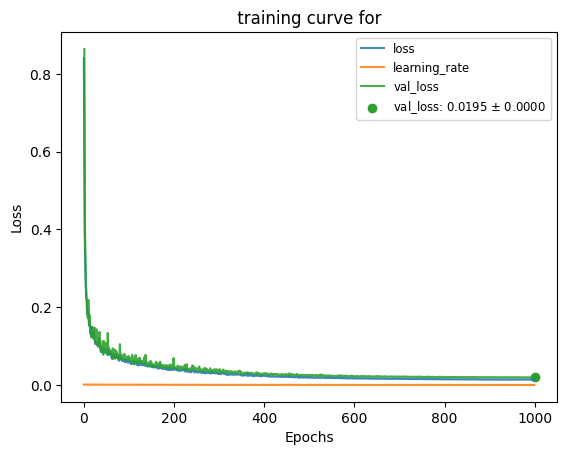

In [10]:
plot_train_test_loss([hist]);

The model can be loaded and saved with keras API.

In [11]:
# model_energy_force.save("model_energy_force")
# model_energy_force = keras.models.load_model('model_energy_force')

For evaluating the predictions, the reference data and the model predictions have to be transformed back to the proper enery and force scale.

In [12]:
scaler.inverse_transform_dataset(dataset)
true_y = dataset_test.get("E"), dataset_test.get("F")

In [13]:
%%capture
import numpy as np
from kgcnn.utils.plots import plot_predict_true
predicted_y = model_energy_force.predict(x_test, verbose=0)
predicted_y = scaler.inverse_transform(
    y=(predicted_y["energy"], predicted_y["force"]), X=dataset_test.get("z"))

Checking the model performance by plotting model predictions of force $\vec{F}=(F_x, F_y, F_z)$ vs. actual values. Ideally all points of the test data fall on the red origin line. 

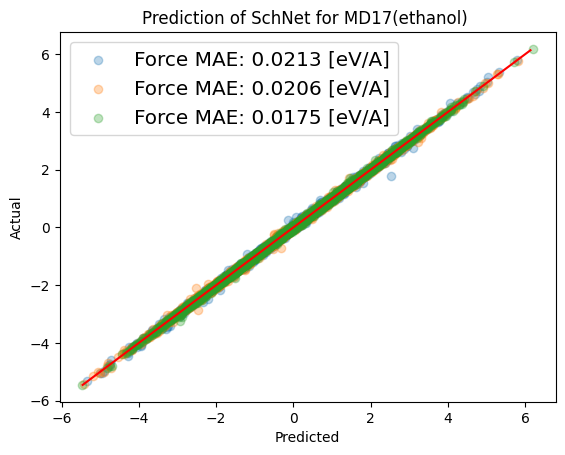

In [14]:
plot_predict_true(np.concatenate([np.array(f) for f in predicted_y[1]], axis=0),
                  np.concatenate([np.array(f) for f in true_y[1]], axis=0),
                  filepath=None, data_unit="eV/A",
                  model_name="SchNet", dataset_name="MD17(ethanol)", target_names="Force",
                  file_name=None);

## Molecular dynamics simulation

To test the GNN for replacing force fields to predict a neural-network potential and gradients, a molecular dynamics simulation can be run with ASE interfaces.

The [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) is a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations.

ASE provides interfaces to different codes through Calculators which are used together with the central Atoms object and the many available algorithms in ASE.

Below there is a Calculator for ``kgcnn``.

#### Keras model in MolDynamicsModelPredictor

In the first instance, the keras model has to be wrapped with the necessary graph pre- ans post processing methods. Also the input and output names of the model has to be matched with the graph data. This is similar to the input layer config and dataset properties.

In [15]:
from kgcnn.molecule.dynamics.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange, CountNodesAndEdges

dyn_model = MolDynamicsModelPredictor(
    model=model_energy_force, 
    model_inputs=config["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[
        SetRange(node_coordinates="R", max_distance=4.0),
        CountNodesAndEdges(total_edges="total_ranges", count_edges="range_indices", count_nodes="z", total_nodes="total_nodes")
    ],
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, force="forces", atomic_number="z")]
)

In [16]:
%%capture
dyn_model(dataset[0:32])[0]["energy"], dataset[0].get("E")

#### Use ASE compatible KgcnnSingleCalculator

For a single keras-model based `MolDynamicsModelPredictor` , a ASE calculator `KgcnnSingleCalculator` can be constructed, which takes a `ase.Atoms` class and calculate the rquired `Calculator` ouput quantities.

To match the `ase.Atoms` and graph properties and their names, use the `AtomsToGraphConverter` class.

In [17]:
from ase import Atoms
from kgcnn.molecule.dynamics.ase_calc import AtomsToGraphConverter

atoms = Atoms(dataset[0]["z"], positions=dataset[0]["R"])
atoms

Atoms(symbols='C2OH6', pbc=False)

In [18]:
conv = AtomsToGraphConverter({"z": "get_atomic_numbers", "R": "get_positions"})
conv(atoms)

<MemoryGraphList [{'z': array([6, 6, 8, 1, 1, 1, 1, 1, 1]), 'R': array([[ 5.52056788e-03,  5.91490056e-01, -8.13817516e-04],
       [-1.25363934e+00, -2.55356778e-01, -2.98005925e-02],
       [ 1.08783065e+00, -3.07554661e-01,  4.82298135e-02],
       [ 6.28212061e-02,  1.28375273e+00, -8.42788551e-01],
       [ 6.05666964e-03,  1.23031210e+00,  8.85346386e-01],
       [-2.21822060e+00,  1.89805043e-01, -5.81601230e-02],
       [-9.10971712e-01, -1.05392634e+00, -7.81595844e-01],
       [-1.19200947e+00, -7.42476834e-01,  9.21966757e-01],
       [ 1.84879848e+00, -2.86324036e-02, -5.25690230e-01]])} ...]>

In [19]:
from kgcnn.molecule.dynamics.ase_calc import KgcnnSingleCalculator

calc = KgcnnSingleCalculator(
    model_predictor=dyn_model, 
    atoms_converter=conv
)

A simple dynamics calculaion with `VelocityVerlet` propagater via ase and the `KgcnnSingleCalculator` .

In [20]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-4210.10445806), 'forces': array([[-0.4319178 ,  1.466453  , -0.08908945],
       [ 2.595021  , -1.8305936 , -0.41477618],
       [ 1.6008677 , -0.07569015, -0.8077605 ],
       [ 0.06489369, -0.2496165 , -0.19408837],
       [ 0.07452087, -0.0137673 ,  0.10405701],
       [-0.45108813,  0.49759647, -0.8265151 ],
       [-1.6828171 ,  1.0527747 ,  0.6928493 ],
       [-0.24742113, -0.6918848 ,  0.57382786],
       [-1.5220588 , -0.15527189,  0.9614955 ]], dtype=float32)}


In [21]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -467.789eV  Ekin = 0.027eV (T=212K)  Etot = -467.762eV
Energy per atom: Epot = -467.809eV  Ekin = 0.047eV (T=362K)  Etot = -467.763eV
Energy per atom: Epot = -467.801eV  Ekin = 0.040eV (T=310K)  Etot = -467.761eV
Energy per atom: Epot = -467.809eV  Ekin = 0.046eV (T=353K)  Etot = -467.763eV
Energy per atom: Epot = -467.808eV  Ekin = 0.046eV (T=353K)  Etot = -467.762eV
Energy per atom: Epot = -467.815eV  Ekin = 0.052eV (T=403K)  Etot = -467.762eV
Energy per atom: Epot = -467.816eV  Ekin = 0.052eV (T=404K)  Etot = -467.764eV
Energy per atom: Epot = -467.806eV  Ekin = 0.043eV (T=334K)  Etot = -467.763eV
Energy per atom: Epot = -467.791eV  Ekin = 0.029eV (T=224K)  Etot = -467.762eV
Energy per atom: Epot = -467.804eV  Ekin = 0.041eV (T=319K)  Etot = -467.762eV
Energy per atom: Epot = -467.807eV  Ekin = 0.045eV (T=345K)  Etot = -467.762eV
Energy per atom: Epot = -467.801eV  Ekin = 0.038eV (T=294K)  Etot = -467.763eV
Energy per atom: Epot = -467.809eV  Ekin = 0.045eV (

> **NOTE**: You can find this page as jupyter notebook in https://github.com/aimat-lab/gcnn_keras/tree/master/docs/source